# Import and load into dataframe

In [293]:
import sqlite3
import pandas as pd

# Connect to your SQLite database
conn = sqlite3.connect('../database.db')

# Load the school data from the database into a DataFrame
df_school = pd.read_sql_query("SELECT * FROM schools", conn)
conn.close()


In [294]:

# Load the school ranking data from the CSV file into a DataFrame
df_ranking = pd.read_csv('../playwright/school_ranking.csv', encoding='ISO-8859-1')


# EDA

## 1) Looking at the data

In [295]:
df_school[['school_id','name',]].sort_values(by='name').head()

,school_id,name
137,142,A. E. Cross School
106,108,Abbeydale School
64,66,Acadia School
117,120,Adolescent Mental Health Services
56,58,Alex Munro School


In [296]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   school_id               250 non-null    int64 
 1   name                    250 non-null    object
 2   address                 250 non-null    object
 3   phone                   250 non-null    object
 4   fax                     250 non-null    object
 5   email                   250 non-null    object
 6   website                 250 non-null    object
 7   school_hour             250 non-null    object
 8   grades                  250 non-null    object
 9   ward                    250 non-null    object
 10  area                    250 non-null    object
 11  total_enrolment         250 non-null    int64 
 12  programs_list           250 non-null    object
 13  desc                    250 non-null    object
 14  kindergarten_enrolment  250 non-null    int64 
 15  grade_

In [297]:
df_ranking['school_name'].head()

0                          BCS@Home
1                Bearspaw Christian
2        Calgary Academy Collegiate
3    Calgary French & International
4                    Calgary Jewish
Name: school_name, dtype: object

In [298]:
df_ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school_name      272 non-null    object 
 1   rank_detail_url  272 non-null    object 
 2   school_rating    272 non-null    float64
 3   school_rank      272 non-null    object 
 4   city             272 non-null    object 
 5   school_group     272 non-null    object 
 6   school_type      272 non-null    object 
dtypes: float64(1), object(6)
memory usage: 15.0+ KB


By looking at "Acadia", the school names in df_ranking are all missing suffix like "School". Also, it appears that not all schools have data in df_ranking.

## 2) Cleaning

### 2a) Simple matching

Convert all names to lowercase, then check if the short version of school names is contained in the full version of school names in database.

In [299]:
df_ranking['is_in'] = df_ranking['school_name'].str.lower().apply(lambda x: any(x in name for name in df_school['name'].str.lower()))

In [300]:
df_ranking['is_in'].value_counts()

is_in
False    166
True     106
Name: count, dtype: int64

In [301]:
df_ranking['is_in'].value_counts(normalize= True)

is_in
False    0.610294
True     0.389706
Name: proportion, dtype: float64

Only 39% of school names matched.

In [302]:
df_ranking[df_ranking['is_in'] == True]

,school_name,rank_detail_url,school_rating,school_rank,city,school_group,school_type,is_in
19,Acadia,/school/ab/elementary/9300,5.9,456/848,Calgary,elementary,Public,True
22,Alex Munro,/school/ab/elementary/9261,2.7,807/848,Calgary,elementary,Public,True
23,Altadore,/school/ab/elementary/9109,7.8,122/848,Calgary,elementary,Public,True
24,Andrew Sibbald,/school/ab/elementary/9336,7.8,122/848,Calgary,elementary,Public,True
25,Annie Foote,/school/ab/elementary/9377,5.3,577/848,Calgary,elementary,Public,True
...,...,...,...,...,...,...,...,...
255,Queen Elizabeth,/school/ab/secondary/9806,6.8,73/253,Calgary,secondary,Public,True
256,Robert Thirsk,/school/ab/secondary/1679,5.6,148/253,Calgary,secondary,Public,True
257,Sir Winston Churchill,/school/ab/secondary/9857,8.4,23/253,Calgary,secondary,Public,True
259,Western Canada,/school/ab/secondary/9816,8.8,15/253,Calgary,secondary,Public,True


### 2b) Looking at the matched and unmatched schools

Create a function to check if a school name in ranking is contained in any of the names in df_school

In [303]:

def check_school(ranking_school):
    for school in df_school['name']:
        if ranking_school.lower() in school.lower():
            return school
    return None

# Apply the function to df_ranking
df_ranking['matching_school'] = df_ranking['school_name'].apply(check_school)



Print out the school names from both dataframes where there was a match

In [304]:
matched_schools_in_df_ranking = df_ranking[df_ranking['matching_school'].notna()][['school_name', 'matching_school']]
matched_schools_in_df_ranking



,school_name,matching_school
19,Acadia,Acadia School
22,Alex Munro,Alex Munro School
23,Altadore,Altadore School
24,Andrew Sibbald,Andrew Sibbald School
25,Annie Foote,Annie Foote School
...,...,...
255,Queen Elizabeth,Queen Elizabeth School
256,Robert Thirsk,Robert Thirsk High School
257,Sir Winston Churchill,Sir Winston Churchill High School
259,Western Canada,Western Canada High School


In [305]:
matched_schools_in_df_ranking.shape

(106, 2)

106 schools successfully matched.

And where there was no match

In [306]:
unmatched_schools_in_df_ranking = df_ranking[df_ranking['matching_school'].isna()]
unmatched_schools_in_df_ranking.sort_values(by='school_rating', ascending=False)[['school_name','school_rank','school_type']].head(10)

,school_name,school_rank,school_type
231,Renert School,1/253,Private
234,Webber,1/253,Private
132,Clear Water,1/848,Separate
232,Rundle College,1/253,Private
18,Webber,1/848,Private
83,Master's,1/848,Public
3,Calgary French & International,1/848,Private
235,West Island College,5/253,Private
14,Renert,10/848,Private
144,Holy Name,12/848,Separate


In [307]:
unmatched_schools_in_df_ranking.value_counts('school_type')

school_type
Separate       100
Private         28
Public          26
Charter          6
Francophone      6
Name: count, dtype: int64

In [308]:
unmatched_schools_in_df_ranking.shape

(166, 9)

The school data in the database was obtained from Calgary Board of Education, which is the largest school board in Alberta for public schools. Therefore, most of the unmatched schools belong to non-public schools. However, there are still 26 unmatched public school, which necessitates further cleaning.

### 2c) More closer look at the unmatched public schools

In [309]:
unmatched_public_schools_in_df_ranking = unmatched_schools_in_df_ranking[unmatched_schools_in_df_ranking['school_type'] == 'Public']
unmatched_public_schools_in_df_ranking['school_name'].head()

20      Al-Amal Academy
21        Alex Ferguson
27             Bearspaw
36    Calgary Christian
37      Calgary Islamic
Name: school_name, dtype: object

In [310]:
matched_schools_in_df_school = df_ranking['matching_school'].dropna().unique()
unmatched_schools_in_df_school = df_school[~df_school['name'].isin(matched_schools_in_df_school)].sort_values(by='name')
'''for name in unmatched_schools_in_df_school['name'].str.replace(' High School','').str.replace(' School',''):
    print(name)'''

"for name in unmatched_schools_in_df_school['name'].str.replace(' High School','').str.replace(' School',''):\n    print(name)"

Make a side-by-side comparison for the unmatched schools, group by alphabets.

In [311]:
from IPython.display import display, HTML

def display_side_by_side(df_list):
    base_url = 'https://www.compareschoolrankings.org'
    html_str = '<table style="background-color:black;color:white;"><tr>'
    for df, cols in df_list:
        if not df.empty:
            if 'rank_detail_url' in cols:
                df = df.copy()  # To avoid modifying the original dataframe
                df['rank_detail_url'] = base_url + df['rank_detail_url'].astype(str)
            html_str += '<td>' + df[cols].to_html(index=False) + '</td>'
    html_str += '</tr></table>'
    return HTML(html_str)

def display_alphabetical(df_list):
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        dfs = []
        for df, cols in df_list:
            filtered_df = df[df[cols[0]].str.lower().str.startswith(letter, na=False)]
            if not filtered_df.empty:
                dfs.append((filtered_df, cols))
        if dfs:
            display(HTML('<h1 style="color:grey;">Names starting with ' + letter.upper() + '</h1>'))
            display(display_side_by_side(dfs))

# Define a list of your DataFrame and column name pairings
df_list = [
    (unmatched_schools_in_df_school, ['name']), 
    (unmatched_public_schools_in_df_ranking, ['school_name', 'rank_detail_url'])
]

# Call the function to display dataframes alphabetically
display_alphabetical(df_list)

name
CBE Home Education
CBe-learn
Canyon Meadows School
Cappy Smart School
Captain Nichola Goddard School
Children's Village School
Chinook Learning Services
Chris Akkerman School
Christine Meikle School
Citadel Park School


name
Dalhousie School
David Thompson School
Discovering Choices - CACY
Discovering Choices II
Douglasdale School
Dr. E.P. Scarlett High School
Dr. E.W. Coffin School
Dr. Freda Miller School
Dr. George Stanley School
Dr. Gladys McKelvie Egbert School


name
Emily Follensbee School
Eric Harvie School
Erin Woods School
Ernest Morrow School
Eugene Coste School
Evergreen School


name
F.E. Osborne School
Fairview School


name
G.W. Skene School
Georges P. Vanier School


name
Keeler School
Kenneth D. Taylor School
King George School


name
Mahogany School
Maple Ridge School
Marlborough School
Marshall Springs School
McKenzie Highlands School
McKenzie Lake School
McKenzie Towne School
MidSun School
Mount Royal School
Mountain Park School


name
Queen Elizabeth High School


name
START Outreach
Saddle Ridge School
Sam Livingston School
Samuel W. Shaw School
Scenic Acres School
Senator Patrick Burns School
Sherwood School
Sibylla Kiddle School
Simon Fraser School
Sir John A. Macdonald School


name
Valley Creek School
Valley View School
Varsity Acres School
Vincent Massey School


name
W.O. Mitchell School
West Dover School
West Ridge School
West Springs School
Westbrook Outreach
William D. Pratt School
William Reid School
William Roper Hull School
Willow Park School
Wilma Hansen School


It is found that some of the names in df_ranking.school_name has extra spaces around apostrophe as compared to df_school.name. 

For example,
'Dr. E.W. Coffin' vs 'Dr. E. W. Coffin'

Also, in one case, an incomplete word is spotted, i.e. 'Alexander Ferguson' vs 'Alex Ferguson'.

### 2d) Optimize cleaning function

In [312]:
import re

def clean_name(name):
    """Clean the school name by removing spaces around periods, converting to lower case, and handling specific cases."""
    name = name.lower()  # Convert to lower case
    name = re.sub('\s*\.\s*', '.', name) # Remove spaces around periods
    
    # Handle specific cases:
    name = name.replace("alex ferguson", "alexander ferguson school") 
    name = name.replace("john g diefenbaker","john g.diefenbaker") 
    return name

# Apply the cleaning function to the school names in both dataframes
df_school['name_cleaned'] = df_school['name'].apply(clean_name)
df_ranking['school_name_cleaned'] = df_ranking['school_name'].apply(clean_name)

Revise the check_school function

In [313]:

def check_school(ranking_school):
    for school in df_school['name_cleaned']:
        if ranking_school in school:
            return school
    return None



# Apply the function to df_ranking
df_ranking['matching_school_cleaned'] = df_ranking['school_name_cleaned'].apply(check_school)



In [314]:
unmatched_schools_in_df_ranking_cleaned = df_ranking[df_ranking['matching_school_cleaned'].isna()]
unmatched_schools_in_df_ranking_cleaned.shape

(161, 11)

In [315]:
unmatched_schools_in_df_ranking_cleaned.value_counts('school_type')

school_type
Separate       100
Private         28
Public          21
Charter          6
Francophone      6
Name: count, dtype: int64

In [316]:
unmatched_public_schools_in_df_ranking_cleaned = unmatched_schools_in_df_ranking_cleaned[unmatched_schools_in_df_ranking_cleaned['school_type']=='Public']

With the current cleaning function, the number of unmatched public school reduced from 26 to 21 only.

In [317]:
matched_schools_in_df_school_cleaned = df_ranking['matching_school_cleaned'].dropna().unique()
unmatched_schools_in_df_school_cleaned = df_school[~df_school['name_cleaned'].isin(matched_schools_in_df_school_cleaned)].sort_values(by='name')

In [318]:
# Define a list of your DataFrame and column name pairings
df_list_cleaned = [(unmatched_schools_in_df_school_cleaned, ['name_cleaned']), (unmatched_public_schools_in_df_ranking_cleaned, ['school_name_cleaned','rank_detail_url'])]

display_alphabetical(df_list_cleaned)

name_cleaned
cbe home education
cbe-learn
canyon meadows school
cappy smart school
captain nichola goddard school
children's village school
chinook learning services
chris akkerman school
christine meikle school
citadel park school


name_cleaned
dalhousie school
david thompson school
discovering choices - cacy
discovering choices ii
douglasdale school
dr.freda miller school
dr.george stanley school
dr.gladys mckelvie egbert school
dr.gordon higgins school
dr.gordon townsend school


name_cleaned
emily follensbee school
eric harvie school
erin woods school
ernest morrow school
eugene coste school
evergreen school


name_cleaned
f.e.osborne school
fairview school


name_cleaned
g.w.skene school
georges p.vanier school


name_cleaned
jack james high school
james short memorial school
janet johnstone school
joane cardinal-schubert high school
john ware school


name_cleaned
keeler school
kenneth d.taylor school
king george school


name_cleaned
mahogany school
maple ridge school
marlborough school
marshall springs school
mckenzie highlands school
mckenzie lake school
mckenzie towne school
midsun school
mount royal school
mountain park school


name_cleaned
queen elizabeth high school


name_cleaned
start outreach
saddle ridge school
sam livingston school
samuel w.shaw school
scenic acres school
senator patrick burns school
sherwood school
sibylla kiddle school
simon fraser school
sir john a.macdonald school


name_cleaned
valley creek school
valley view school
varsity acres school
vincent massey school


name_cleaned
w.o.mitchell school
west dover school
west ridge school
west springs school
westbrook outreach
william d.pratt school
william reid school
william roper hull school
willow park school
wilma hansen school


Upon closer examination of the current filtered results, it appears that all the remaining public schools that have not been matched are not part of the Calgary Board of Education (CBE). After conducting a quick internet search, it was found that these schools belong to other school boards or districts, such as the Palliser School District.

Please note that the attendance areas for these schools are not readily available, and in some cases, they may not have defined attendance areas. For practical reasons, this project will focus solely on schools within the Calgary Board of Education (CBE).

https://www.pallisersd.ab.ca/schools/our-schools

## Matching of school ID

In [319]:
df_ranking_db= df_ranking[~df_ranking['matching_school_cleaned'].isna()].copy()


Performing matching of school_id, which will serve as foreign keys.

In [320]:
def check_school_id(ranking_school):
    for row in df_school.itertuples():
        
        if ranking_school in row.name_cleaned:
            return row.school_id
    return None

df_ranking_db['school_id'] = df_ranking_db['school_name_cleaned'].apply(check_school_id)

Check for duplicates.

In [321]:
df_ranking_db['school_id'].value_counts()

school_id
43     3
66     1
6      1
61     1
101    1
      ..
135    1
16     1
15     1
234    1
174    1
Name: count, Length: 109, dtype: int64

Look at the duplicates found at school_id 43.

In [322]:
df_ranking_db[df_ranking_db['school_id']== 43]

,school_name,rank_detail_url,school_rating,school_rank,city,school_group,school_type,is_in,matching_school,school_name_cleaned,matching_school_cleaned,school_id
97,Queen Elizabeth,/school/ab/elementary/9227,7.5,167/848,Calgary,elementary,Public,True,Queen Elizabeth School,queen elizabeth,queen elizabeth school,43
98,Queen Elizabeth,/school/ab/elementary/3143,3.8,754/848,Calgary,elementary,Public,True,Queen Elizabeth School,queen elizabeth,queen elizabeth school,43
255,Queen Elizabeth,/school/ab/secondary/9806,6.8,73/253,Calgary,secondary,Public,True,Queen Elizabeth School,queen elizabeth,queen elizabeth school,43


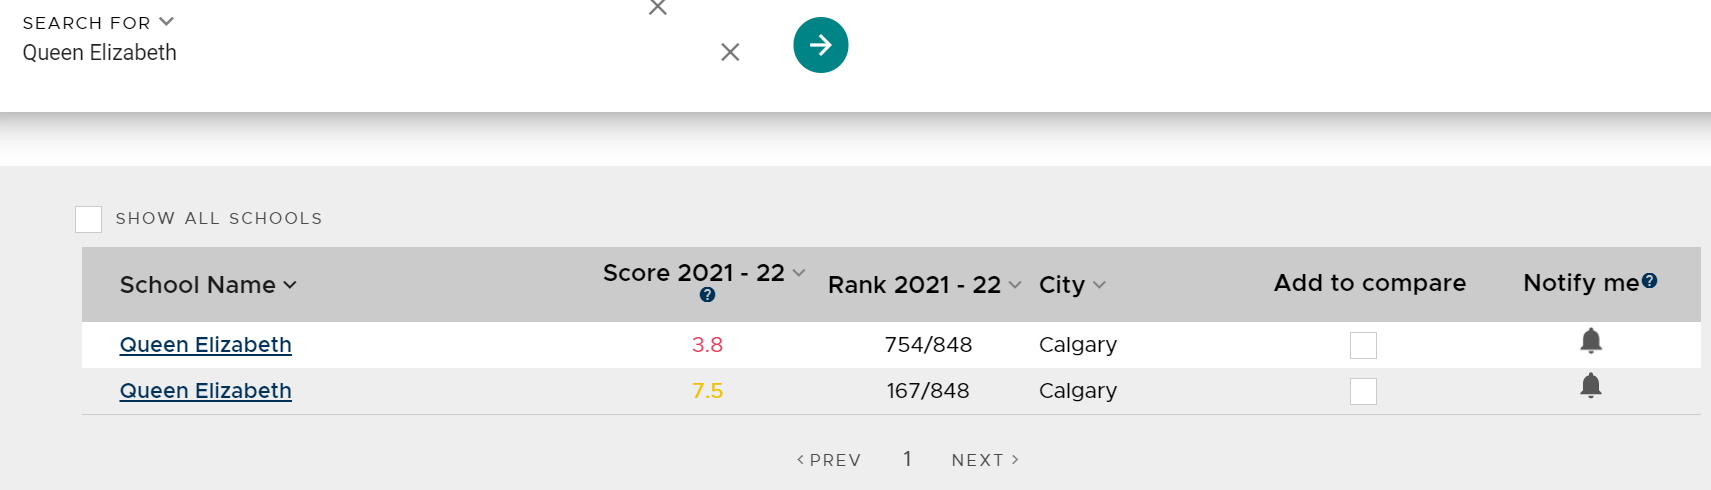

Checked from Fraser's website, there are indeed two entries in elementary school having the name "Queen Elizabeth. As they have the same phone number and website, it is likely a data error.

Since the secondary school has a rating of 6.8, I will keep the elementary school entry with index 97 for it having a rating closest to 6.8, and drop the entry with index 98.

In [323]:
df_ranking_db.drop(index=98, axis=0,inplace=True)

Now the matching of school_id is finished, drop all unnecessary columns and double check for duplicates.

In [324]:
df_ranking_db.drop(['is_in','matching_school','school_name_cleaned','matching_school_cleaned'],axis=1, inplace=True)

In [325]:
df_ranking_db.drop_duplicates()
df_ranking_db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, 19 to 260
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school_name      110 non-null    object 
 1   rank_detail_url  110 non-null    object 
 2   school_rating    110 non-null    float64
 3   school_rank      110 non-null    object 
 4   city             110 non-null    object 
 5   school_group     110 non-null    object 
 6   school_type      110 non-null    object 
 7   school_id        110 non-null    int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 7.7+ KB


Now df_ranking_db is ready for insertion into the database.

In [326]:
df_ranking_db.to_csv('school_ranking_cleaned.csv', index=False)